Epoch 1/100


C:\Users\jeonn\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.1622 - val_loss: 0.0325
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0344 - val_loss: 0.0166
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0104 - val_loss: 0.0141
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0094 - val_loss: 0.0138
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0085 - val_loss: 0.0131
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0075 - val_loss: 0.0128
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0077 - val_loss: 0.0123
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0072 - val_loss: 0.0128
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0070 - val_loss: 0.0119
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0074 - val_loss: 0.0119
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0

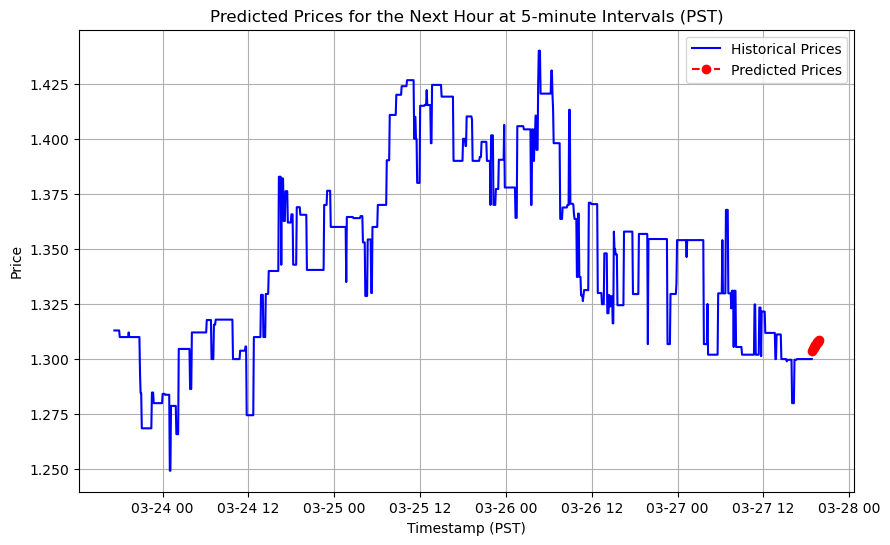

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pytz
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import random
import os

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Directory containing the JSON files
json_dir = r'C:\Users\jeonn\OneDrive\Desktop\Crypto\Flux'

# List all JSON files in the directory
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

# Initialize an empty list to store dataframes
dfs = []

# Iterate over each JSON file
for json_file in json_files:
    # Read the JSON file into a dataframe
    df = pd.read_json(os.path.join(json_dir, json_file))
    
    # Ensure that all required columns are present
    required_columns = ['price', 'qty', 'vwap', 'bid_ask_spread']
    for col in required_columns:
        if col not in df.columns:
            print(f"Warning: Column '{col}' missing in file: {json_file}")
    
    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs).sort_index()

# Find the timestamp column name
timestamp_col = df.columns[df.columns.str.contains('timestamp', case=False)].tolist()[0]

# Convert timestamp from Unix timestamp to datetime
df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='s')

# Handle duplicate timestamps by aggregating them
df_grouped = df.groupby(timestamp_col).agg({
    'price': 'mean',
    'qty': 'sum',
    'vwap': 'mean',
    'bid_ask_spread': 'mean'
}).reset_index()

# Set timestamp as index
df_grouped.set_index(timestamp_col, inplace=True)

# Resample to 5-minute intervals and forward-fill missing values
df_resampled = df_grouped.resample('5T').ffill()

df = df_resampled

# drop the first row because it will always be  filled NaN
df = df.iloc[1: , :]
# Convert timestamp to datetime and set as index
#df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
#df.set_index('timestamp', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define window size for time series data
window_size = 24

# Create sequences and labels
sequences = []
labels = []
for i in range(len(scaled_data) - window_size):
    sequences.append(scaled_data[i:i+window_size])
    labels.append(scaled_data[i+window_size])

# Convert sequences and labels to numpy arrays
X = np.array(sequences)
y = np.array(labels)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, X.shape[2])),
    Dense(X.shape[2])
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define early stopping to prevent overfitting
# Adjusting patience up to ~35 seems to produce more realistic results
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Predict prices for the next hour at 5-minute intervals
num_steps_to_predict = 12  # For an hour at 5-minute intervals
input_data = scaled_data[-window_size:]  # Start with the last window_size data points

predicted_prices = []
for _ in range(num_steps_to_predict):
    # Reshape input data to match model input shape
    input_data_reshaped = np.expand_dims(input_data, axis=0)
    
    # Make prediction for the next time step
    predicted_scaled_price = model.predict(input_data_reshaped)
    
    # Append the predicted price to the list of predicted prices
    predicted_prices.append(predicted_scaled_price[0])
    
    # Update the input data for the next time step by shifting the window
    input_data = np.roll(input_data, -1, axis=0)
    input_data[-1] = predicted_scaled_price[0]

# Inverse transform the predicted prices
predicted_prices = scaler.inverse_transform(np.array(predicted_prices))

# Get the current time from the original DataFrame
current_time = df.index[-1]

# Create time stamps for each prediction
timestamps = [current_time + timedelta(minutes=(i+1)*5) for i in range(num_steps_to_predict)]

# Convert timestamps to PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')
timestamps_pst = [timestamp.tz_localize('UTC').tz_convert(pst_timezone) for timestamp in timestamps]

# Print the timestamps and corresponding predicted prices in PST timezone
print("Timestamp (PST)\t\t\tPredicted Price")
for timestamp, price in zip(timestamps_pst, predicted_prices):
    print(f"{timestamp}\t{price[0]}")

# Plot the historical prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, scaler.inverse_transform(scaled_data)[:, 0], label='Historical Prices', color='blue')

# Plot the predicted prices
plt.plot(timestamps_pst, predicted_prices[:, 0], marker='o', linestyle='dashed', label='Predicted Prices', color='red')

plt.xlabel('Timestamp (PST)')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next Hour at 5-minute Intervals (PST)')
plt.legend()
plt.grid(True)
plt.show()

# Work out resample and aggregation to create consistent time interval.

In [66]:
import pandas as pd

# Load and preprocess data from multiple JSON files
df1 = pd.read_json('FLUX-USDT_2024-03-25.json')
df2 = pd.read_json('FLUX-USDT_2024-03-26.json')

# Concatenate dataframes and sort by timestamp
df = pd.concat([df1, df2]).sort_values(by='timestamp')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Add one second to duplicate timestamps
duplicate_timestamps = df[df.duplicated('timestamp')]['timestamp']
df.loc[df['timestamp'].isin(duplicate_timestamps), 'timestamp'] += pd.Timedelta(seconds=1)

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Resample to 5-minute intervals and forward fill missing values
df_resampled = df.groupby(pd.Grouper(freq='5T')).ffill()

# Ensure index uniqueness by resetting index and dropping duplicates
df_resampled.reset_index(inplace=True)
df_resampled.drop_duplicates(subset='timestamp', inplace=True)

# Set timestamp as index again
df_resampled.set_index('timestamp', inplace=True)

# Display resampled DataFrame
print(df_resampled)

                        price        qty      vwap  bid_ask_spread
timestamp                                                         
2024-03-25 00:06:01  1.376226   0.797689  1.295877       -0.033405
2024-03-25 00:29:03  1.360000   1.468300  1.295900       -0.010469
2024-03-25 00:29:59  1.362000   3.613900  1.293847       -0.008469
2024-03-25 00:55:15  1.365722   5.165714  1.293240       -0.003722
2024-03-25 01:13:11  1.362000   0.002038  1.292008       -0.002000
...                       ...        ...       ...             ...
2024-03-26 22:08:49  1.350000   0.047814  1.331768       -0.007879
2024-03-26 22:16:22  1.345000  13.105161  1.331642       -0.012880
2024-03-26 22:34:39  1.345000   0.012703  1.331642       -0.020538
2024-03-26 22:34:45  1.324462   5.058325  1.331600       -0.031361
2024-03-26 23:26:31  1.357880   3.756023  1.331139       -0.047880

[282 rows x 4 columns]


<h2 style="color:green">Preferred resample method so far</h2>.

In [13]:
import pandas as pd

# Your provided data
data = pd.read_json('FLUX-USDT_2024-03-26.json')

# Convert data to DataFrame
df = pd.DataFrame(data)

# Convert timestamp from Unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Handle duplicate timestamps by aggregating them
df_grouped = df.groupby('timestamp').agg({
    'price': 'mean',
    'qty': 'sum',
    'vwap': 'mean',
    'bid_ask_spread': 'mean'
}).reset_index()

# Set timestamp as index
df_grouped.set_index('timestamp', inplace=True)

# Resample to 5-minute intervals and forward-fill missing values
df_resampled = df_grouped.resample('5T').ffill()

print(df_resampled)

                        price        qty      vwap  bid_ask_spread
timestamp                                                         
2024-03-26 00:55:00       NaN        NaN       NaN             NaN
2024-03-26 01:00:00  1.400000  10.875000  1.367673       -0.011273
2024-03-26 01:05:00  1.400000  10.875000  1.367673       -0.011273
2024-03-26 01:10:00  1.400000  10.875000  1.367673       -0.011273
2024-03-26 01:15:00  1.400000   6.068516  1.367843       -0.010162
...                       ...        ...       ...             ...
2024-03-26 23:05:00  1.324462   5.058325  1.331600       -0.031361
2024-03-26 23:10:00  1.324462   5.058325  1.331600       -0.031361
2024-03-26 23:15:00  1.324462   5.058325  1.331600       -0.031361
2024-03-26 23:20:00  1.324462   5.058325  1.331600       -0.031361
2024-03-26 23:25:00  1.324462   5.058325  1.331600       -0.031361

[271 rows x 4 columns]


In [26]:
import pandas as pd

# Initialize an empty list to store dataframes
dfs = []

# Iterate over each JSON file
for json_file in json_files:
    # Read the JSON file into a dataframe
    df = pd.read_json(os.path.join(json_dir, json_file))
    print(f"Reading file: {json_file}, DataFrame shape: {df.shape}")  # Debug statement
    # Convert timestamp to datetime and set as index
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    # Ensure that all required columns are present
    required_columns = ['price', 'qty', 'vwap', 'bid_ask_spread']
    for col in required_columns:
        if col not in df.columns:
            print(f"Warning: Column '{col}' missing in file: {json_file}")
    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs)#.sort_index()
#print(f"Concatenated DataFrame shape: {df.shape}")  # Debug statement


# Convert data to DataFrame
#df = pd.DataFrame(data)

# Convert timestamp from Unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Handle duplicate timestamps by aggregating them
df_grouped = df.groupby('timestamp').agg({
    'price': 'mean',
    'qty': 'sum',
    'vwap': 'mean',
    'bid_ask_spread': 'mean'
}).reset_index()

# Set timestamp as index
df_grouped.set_index('timestamp', inplace=True)

# Resample to 5-minute intervals and forward-fill missing values
df_resampled = df_grouped.resample('5T').ffill()


print(df_resampled)

Reading file: FLUX-USDT_2024-03-24.json, DataFrame shape: (99, 5)
Reading file: FLUX-USDT_2024-03-25.json, DataFrame shape: (67, 5)
Reading file: FLUX-USDT_2024-03-26.json, DataFrame shape: (289, 5)
Reading file: FLUX-USDT_2024-03-27.json, DataFrame shape: (170, 5)
Reading file: FLUX-USDT_2024-03-28.json, DataFrame shape: (4, 5)


KeyError: 'timestamp'

In [27]:
import os
import pandas as pd

# Directory containing the JSON files
json_dir = r'C:\Users\jeonn\OneDrive\Desktop\Crypto\Flux'

# List all JSON files in the directory
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

# Initialize an empty list to store dataframes
dfs = []

# Iterate over each JSON file
for json_file in json_files:
    # Read the JSON file into a dataframe
    df = pd.read_json(os.path.join(json_dir, json_file))
    
    # Ensure that all required columns are present
    required_columns = ['price', 'qty', 'vwap', 'bid_ask_spread']
    for col in required_columns:
        if col not in df.columns:
            print(f"Warning: Column '{col}' missing in file: {json_file}")
    
    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs).sort_index()

# Find the timestamp column name
timestamp_col = df.columns[df.columns.str.contains('timestamp', case=False)].tolist()[0]

# Convert timestamp from Unix timestamp to datetime
df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='s')

# Handle duplicate timestamps by aggregating them
df_grouped = df.groupby(timestamp_col).agg({
    'price': 'mean',
    'qty': 'sum',
    'vwap': 'mean',
    'bid_ask_spread': 'mean'
}).reset_index()

# Set timestamp as index
df_grouped.set_index(timestamp_col, inplace=True)

# Resample to 5-minute intervals and forward-fill missing values
df_resampled = df_grouped.resample('5T').ffill()

print(df_resampled)

                        price        qty      vwap  bid_ask_spread
timestamp                                                         
2024-03-24 00:10:00       NaN        NaN       NaN             NaN
2024-03-24 00:15:00  1.312998   1.284829  1.333910       -0.006344
2024-03-24 00:20:00  1.312998   1.284829  1.333910       -0.006344
2024-03-24 00:25:00  1.312998   1.284829  1.333910       -0.006344
2024-03-24 00:30:00  1.312998   1.284829  1.333910       -0.006344
...                       ...        ...       ...             ...
2024-03-28 01:25:00  1.300000  12.000000  1.308024       -0.019998
2024-03-28 01:30:00  1.300000  12.000000  1.308024       -0.019998
2024-03-28 01:35:00  1.300000  12.000000  1.308024       -0.019998
2024-03-28 01:40:00  1.300000  12.000000  1.308024       -0.019998
2024-03-28 01:45:00  1.300000  12.000000  1.308024       -0.019998

[1172 rows x 4 columns]
